# Tuning Model Paramters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [28]:
train = pd.read_csv('cs-training.csv')
train = train.drop(labels='MonthlyIncome', axis=1)
train['NumberOfDependents'] = train['NumberOfDependents'].fillna(0)
train = train[train['age'] > 0]

In [10]:
target = 'SeriousDlqin2yrs'
predictors = [x for x in train.columns if x != 'SeriousDlqin2yrs']
SEED=10

In [4]:
# function to create gradient boosting models and perform cross validation

def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['SeriousDlqin2yrs'])
        
    #Predict training set:
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['SeriousDlqin2yrs'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("AUC Score (Train): %f" % roc_auc_score(dtrain['SeriousDlqin2yrs'], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

AUC Score (Train): 0.866841
CV Score : Mean - 0.8624254 | Std - 0.003340385 | Min - 0.8592647 | Max - 0.868591


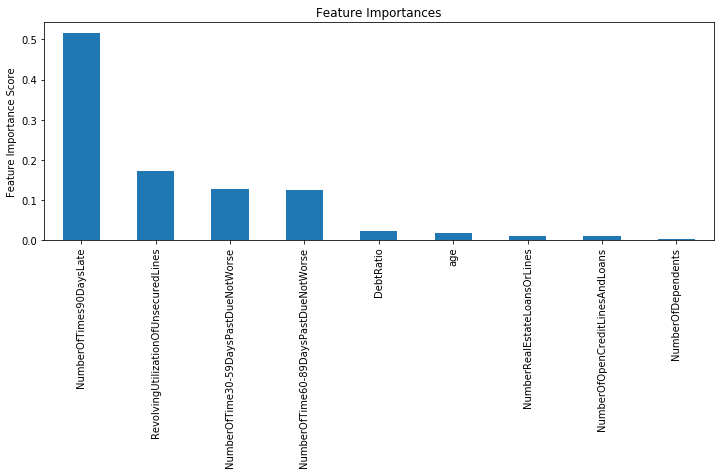

In [25]:
# Create baseline model

gbm0 = GradientBoostingClassifier(random_state=SEED)
modelfit(gbm0, train, predictors)

In [12]:
# Fix learning rate at 0.2 and test for optimal number of trees

param_test1 = {'n_estimators':range(20,91,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.3,
                                                               min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=5,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=SEED), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler

C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_sa...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 91, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [13]:
# optimal number of estimators for a learning rate of 0.3 is 70
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 70}, 0.862048792352746)

## Tuning Tree Parameters

In [15]:
# test for optimal max_depth and min_samples_split 

param_test2 = {'max_depth':range(2,8,1), 'min_samples_split':range(100,1001,100)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.3, 
                                                               n_estimators=70, 
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=SEED), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.best_params_, gsearch2.best_score_

C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler

C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler

C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler

C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler

C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler

C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler

C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler

C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler

({'max_depth': 3, 'min_samples_split': 300}, 0.86231008168578)

In [18]:
# test for optimal min_samples_leaf

param_test3 = {'min_samples_leaf':range(40,81,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.3, 
                                                               n_estimators=70,
                                                               max_depth=3,
                                                               min_samples_split=300,
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=SEED), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.best_params_, gsearch3.best_score_

C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler

({'min_samples_leaf': 70}, 0.8625364612671389)

In [19]:
# test for optimal max_features

param_test4 = {'max_features':range(2,7,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.3,
                                                               n_estimators=70,
                                                               max_depth=3,
                                                               min_samples_split=300,
                                                               min_samples_leaf=70,
                                                               subsample=0.8,
                                                               random_state=SEED),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.best_params_, gsearch4.best_score_

C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler

({'max_features': 4}, 0.8625610999194043)

##### Best tree-parameters for learning rate 0.3 and n_estimators 70:

1. min_samples_split = 300
2. min_samples_leaf = 70
3. max_depth = 3
4. max_features = 4

## Tuning subsample

In [21]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.3,
                                                               n_estimators=70,
                                                               max_depth=3,
                                                               min_samples_split=300,
                                                               min_samples_leaf=70,
                                                               max_features=4,
                                                               random_state=SEED),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.best_params_, gsearch5.best_score_

C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Yvonne\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler

({'subsample': 0.85}, 0.8626794000927804)

## Lower learning rate and increase number of estimators proportionally

AUC Score (Train): 0.867856
CV Score : Mean - 0.8633726 | Std - 0.003131138 | Min - 0.8601675 | Max - 0.8689591


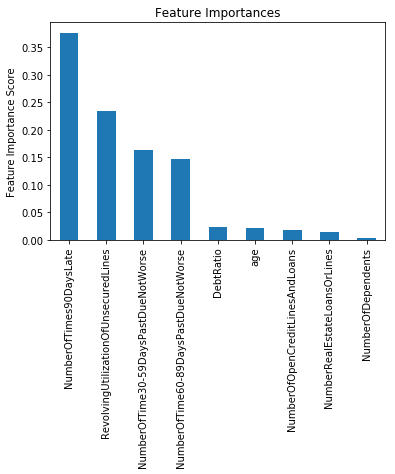

In [22]:
# decrease learning rate by half and double the number of estimators

gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.15,
                                         n_estimators=140,
                                         max_depth=3, 
                                         min_samples_split=300,
                                         min_samples_leaf=70, 
                                         max_features=4,
                                         subsample=0.85, 
                                         random_state=SEED)
modelfit(gbm_tuned_1, train, predictors)

AUC Score (Train): 0.868059
CV Score : Mean - 0.8636801 | Std - 0.003155764 | Min - 0.8605572 | Max - 0.8693135


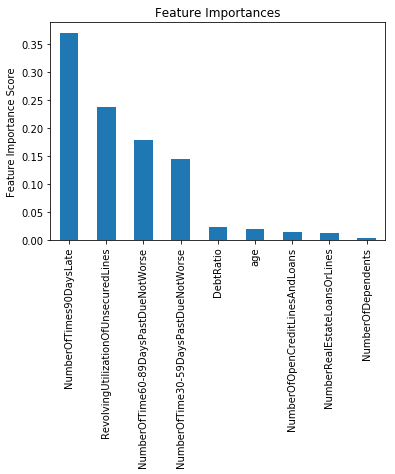

In [23]:
# decrease learning rate by half and double the number of estimators

gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.075,
                                         n_estimators=280,
                                         max_depth=3, 
                                         min_samples_split=300,
                                         min_samples_leaf=70, 
                                         max_features=4,
                                         subsample=0.85, 
                                         random_state=SEED)
modelfit(gbm_tuned_2, train, predictors)

AUC Score (Train): 0.874175
CV Score : Mean - 0.8638479 | Std - 0.003139474 | Min - 0.8605409 | Max - 0.8692547


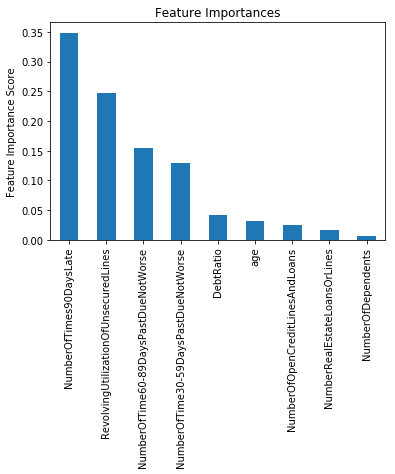

In [24]:
# decrease learning rate by half and double the number of estimators

gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.0375,
                                         n_estimators=2560,
                                         max_depth=3, 
                                         min_samples_split=300,
                                         min_samples_leaf=70, 
                                         max_features=4,
                                         subsample=0.85, 
                                         random_state=SEED)
modelfit(gbm_tuned_3, train, predictors)

AUC Score (Train): 0.872693
CV Score : Mean - 0.8654139 | Std - 0.00282663 | Min - 0.8624017 | Max - 0.870637


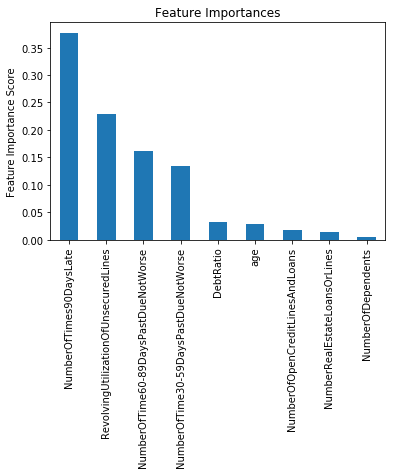

In [30]:
# decrease learning rate further and increase the number of estimators
# selected model

gbm_tuned_4 = GradientBoostingClassifier(learning_rate=0.01,
                                         n_estimators=5300,
                                         max_depth=3, 
                                         min_samples_split=300,
                                         min_samples_leaf=70, 
                                         max_features=4,
                                         subsample=0.85, 
                                         random_state=SEED)
modelfit(gbm_tuned_4, train, predictors)

In [38]:
predictors

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

## Making prediction on test set using chosen model

In [41]:
test = pd.read_csv('cs-test.csv')
test = test.drop(labels='MonthlyIncome', axis=1)
test['NumberOfDependents'] = test['NumberOfDependents'].fillna(0)
test = test[test['age'] > 0]
test = test.drop('SeriousDlqin2yrs', axis=1)

In [71]:
test_pred_prob = gbm_tuned_4.predict_proba(test)[:,1]

In [84]:
test_pred_prob_df = pd.DataFrame(test_pred_prob.tolist())
test_pred_prob_df['Id'] = np.arange(1,101504)
test_pred_prob_df = test_pred_prob_df[['Id', 0]].rename(columns={0:'Probability'})

In [85]:
test_pred_prob_df.to_csv('test predictions.csv')